# 1. Introduction

Here is an Exploratory Data Analysis for the Two Sigma: Using News to Predict Stock Movements 
within the R environment. In this competition, you must predict a signed confidence value, y^ti∈[−1,1] , which is multiplied by the market-adjusted return of a given `assetCode` over a ten day window. If you expect a stock to have a large positive return--compared to the broad market--over the next ten days, you might assign it a large, positive `confidenceValue` (near 1.0). If you expect a stock to have a negative return, you might assign it a large, negative `confidenceValue` (near -1.0). If unsure, you might assign it a value near zero.

For each day in the evaluation time period, we calculate:

$$x_{t} = \sum_{i}\hat y_{ti}r_{ti}u_{ti}$$

where rti is the 10-day market-adjusted leading return for day t for instrument i, and uti is a 0/1 `universe` variable (see the data description for details) that controls whether a particular asset is included in scoring on a particular day.

Your submission score is then calculated as the mean divided by the standard deviation of your daily xt values:

$$score = \frac{\bar x_{t}}{\sigma(x_{t})}.$$

If the standard deviation of predictions is 0, the score is defined as 0.

**Note :** According to the discussion below, it seems that R does not work yet.   
https://www.kaggle.com/c/two-sigma-financial-news/discussion/66831

# 2. Preparations
## 2.1 Load libraries

In [1]:
import pandas as pd
import numpy as np
import time
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2)

import warnings 
warnings.filterwarnings('ignore')
import os

In the data file description,
`About this file This is just a sample of the market data. You should not use this data directly.
Instead, call env.get_training_data() from the twosigmanews package to get the full training sets in your Kernel.`

so you download directly below. I using DJ sterling kernel(https://www.kaggle.com/dster/two-sigma-news-official-getting-started-kernel) thnaks 

In [2]:
from kaggle.competitions import twosigmanews
# You can only call make_env() once, so don't lose it!
env = twosigmanews.make_env()
print('Done!')

Loading the data... This could take a minute.
Done!


## 2.2 Load train_data

In [3]:
(market_train_df, news_train_df) = env.get_training_data()

In [4]:
print("In total: ", market_train_df.shape)

In total:  (4072956, 16)


In [9]:
market_train_df.head()

time   ...    universe
0 2007-02-01 22:00:00+00:00   ...         1.0
1 2007-02-01 22:00:00+00:00   ...         0.0
2 2007-02-01 22:00:00+00:00   ...         1.0
3 2007-02-01 22:00:00+00:00   ...         1.0
4 2007-02-01 22:00:00+00:00   ...         1.0

[5 rows x 16 columns]

In [6]:
market_train_df.shape

(4072956, 16)

In [10]:
print("In total: ", news_train_df.shape)

In total:  (9328750, 35)


In [11]:
news_train_df.head()

time      ...       volumeCounts7D
0 2007-01-01 04:29:32+00:00      ...                    7
1 2007-01-01 07:03:35+00:00      ...                    3
2 2007-01-01 11:29:56+00:00      ...                   17
3 2007-01-01 12:08:37+00:00      ...                   15
4 2007-01-01 12:08:37+00:00      ...                    0

[5 rows x 35 columns]

## 2.3 Load test_data

In [12]:
days = env.get_prediction_days()
(market_obs_df, news_obs_df, predictions_template_df) = next(days)

In [13]:
print("In total: ", market_obs_df.shape)

In total:  (1823, 14)


In [14]:
market_obs_df.head()

close           ...             returnsClosePrevMktres1
0   46.49           ...                            0.009812
1   28.83           ...                            0.015256
2   46.30           ...                           -0.026595
3   31.90           ...                           -0.020835
4  170.60           ...                           -0.001344

[5 rows x 14 columns]

In [15]:
print("In total: ", news_obs_df.shape)

In total:  (2776, 35)


In [16]:
news_obs_df.head()

time      ...       volumeCounts7D
0 2016-12-30 22:00:02+00:00      ...                    0
1 2016-12-30 22:00:02+00:00      ...                    0
2 2016-12-30 22:00:06+00:00      ...                    0
3 2016-12-30 22:00:06+00:00      ...                    2
4 2016-12-30 22:00:17+00:00      ...                    1

[5 rows x 35 columns]

In [17]:
predictions_template_df.head()

assetCode  confidenceValue
0       A.N              0.0
1      AA.N              0.0
2     AAL.O              0.0
3     AAN.N              0.0
4     AAP.N              0.0

## 2.4 Data Description
### Market data
Market data
The data includes a subset of US-listed instruments. The set of included instruments changes daily and is determined based on the amount traded and the availability of information. This means that there may be instruments that enter and leave this subset of data. There may therefore be gaps in the data provided, and this does not necessarily imply that that data does not exist (those rows are likely not included due to the selection criteria).

The marketdata contains a variety of returns calculated over different timespans. All of the returns in this set of marketdata have these properties:

- Returns are always calculated either open-to-open (from the opening time of one trading day to the open of another) or close-to-close (from the closing time of one trading day to the open of another).
- Returns are either raw, meaning that the data is not adjusted against any benchmark, or market-residualized (Mktres), meaning that the movement of the market as a whole has been accounted for, leaving only movements inherent to the instrument.
- Returns can be calculated over any arbitrary interval. Provided here are 1 day and 10 day horizons.
- Returns are tagged with 'Prev' if they are backwards looking in time, or 'Next' if forwards looking.

Within the marketdata, you will find the following columns:

- time(datetime64[ns, UTC]) - the current time (in marketdata, all rows are taken at 22:00 UTC)
- assetCode(object) - a unique id of an asset
- assetName(category) - the name that corresponds to a group of assetCodes. These may be "Unknown" if the corresponding assetCode does not have any rows in the news data.
- universe(float64) - a boolean indicating whether or not the instrument on that day will be included in scoring. This value is not provided outside of the training data time period. The trading universe on a given date is the set of instruments that are avilable for trading (the scoring function will not consider instruments that are not in the trading universe). The trading universe changes daily.
- volume(float64) - trading volume in shares for the day
- close(float64) - the close price for the day (not adjusted for splits or dividends)
- open(float64) - the open price for the day (not adjusted for splits or dividends)
- returnsClosePrevRaw1(float64) - see returns explanation above
- returnsOpenPrevRaw1(float64) - see returns explanation above
- returnsClosePrevMktres1(float64) - see returns explanation above
- returnsOpenPrevMktres1(float64) - see returns explanation above
- returnsClosePrevRaw10(float64) - see returns explanation above
- returnsOpenPrevRaw10(float64) - see returns explanation above
- returnsClosePrevMktres10(float64) - see returns explanation above
- returnsOpenPrevMktres10(float64) - see returns explanation above
- returnsOpenNextMktres10(float64) - 10 day, market-residualized return. This is the target variable used in competition scoring. The market data has been filtered such that returnsOpenNextMktres10 is always not null.

### News data
The news data contains information at both the news article level and asset level (in other words, the table is intentionally not normalized).

- time(datetime64[ns, UTC]) - UTC timestamp showing when the data was available on the feed (second precision)
- sourceTimestamp(datetime64[ns, UTC]) - UTC timestamp of this news item when it was created
- firstCreated(datetime64[ns, UTC]) - UTC timestamp for the first version of the item
- sourceId(object) - an Id for each news item
- headline(object) - the item's headline
- urgency(int8) - differentiates story types (1: alert, 3: article)
- takeSequence(int16) - the take sequence number of the news item, starting at 1. For a given story, alerts and articles have separate sequences.
- provider(category) - identifier for the organization which provided the news item (e.g. RTRS for Reuters News, BSW for Business Wire)
- subjects(category) - topic codes and company identifiers that relate to this news item. Topic codes describe the news item's subject matter. These can cover asset classes, geographies, events, industries/sectors, and other types.
- audiences(category) - identifies which desktop news product(s) the news item belongs to. They are typically tailored to specific audiences. (e.g. "M" for Money International News Service and "FB" for French General News Service)
- bodySize(int32) - the size of the current version of the story body in characters
- companyCount(int8) - the number of companies explicitly listed in the news item in the subjects field
- headlineTag(object) - the Thomson Reuters headline tag for the news item
- marketCommentary(bool) - boolean indicator that the item is discussing general market conditions, such as "After the Bell" summaries
- sentenceCount(int16) - the total number of sentences in the news item. Can be used in conjunction with firstMentionSentence to determine the relative position of the first mention in the item.
- wordCount(int32) - the total number of lexical tokens (words and punctuation) in the news item
- assetCodes(category) - list of assets mentioned in the item
- assetName(category) - name of the asset
- firstMentionSentence(int16) - the first sentence, starting with the headline, in which the scored asset is mentioned.
    -  1: headline
    - 2: first sentence of the story body
    - 3: second sentence of the body, etc
    - 0: the asset being scored was not found in the news item's headline or body text. As a result, the entire news item's text (headline + body) will be used to determine the sentiment score.
- relevance(float32) - a decimal number indicating the relevance of the news item to the asset. It ranges from 0 to 1. If the asset is mentioned in the headline, the relevance is set to 1. When the item is an alert (urgency == 1), relevance should be gauged by firstMentionSentence instead.
- sentimentClass(int8) - indicates the predominant sentiment class for this news item with respect to the asset. The indicated class is the one with the highest probability.
- sentimentNegative(float32) - probability that the sentiment of the news item was negative for the asset
- sentimentNeutral(float32) - probability that the sentiment of the news item was neutral for the asset
- sentimentPositive(float32) - probability that the sentiment of the news item was positive for the asset
- sentimentWordCount(int32) - the number of lexical tokens in the sections of the item text that are deemed relevant to the asset. This can be used in conjunction with wordCount to determine the proportion of the news item discussing the asset.
- noveltyCount12H(int16) - The 12 hour novelty of the content within a news item on a particular asset. It is calculated by comparing it with the asset-specific text over a cache of previous news items that contain the asset.
- noveltyCount24H(int16) - same as above, but for 24 hours
- noveltyCount3D(int16) - same as above, but for 3 days
- noveltyCount5D(int16) - same as above, but for 5 days
- noveltyCount7D(int16) - same as above, but for 7 days
- volumeCounts12H(int16) - the 12 hour volume of news for each asset. A cache of previous news items is maintained and the number of news items that mention the asset within each of five historical periods is calculated.
- volumeCounts24H(int16) - same as above, but for 24 hours
- volumeCounts3D(int16) - same as above, but for 3 days
- volumeCounts5D(int16) - same as above, but for 5 days
- volumeCounts7D(int16) - same as above, but for 7 days

# 3. Simple Exploration
## 3.1 Check null data
- Market

In [18]:
percent = (100 * market_train_df.isnull().sum() / market_train_df.shape[0]).sort_values(ascending=False)
percent[:10]

returnsOpenPrevMktres10     2.284680
returnsClosePrevMktres10    2.283599
returnsOpenPrevMktres1      0.392540
returnsClosePrevMktres1     0.392344
universe                    0.000000
returnsOpenNextMktres10     0.000000
returnsOpenPrevRaw10        0.000000
returnsClosePrevRaw10       0.000000
returnsOpenPrevRaw1         0.000000
returnsClosePrevRaw1        0.000000
dtype: float64

In [19]:
percent1 = (100 * market_obs_df.isnull().sum() / market_obs_df.shape[0]).sort_values(ascending=False)
percent1[:10]

returnsOpenPrevMktres10     2.029622
returnsClosePrevMktres10    2.029622
returnsClosePrevMktres1     0.658256
returnsOpenPrevMktres1      0.658256
time                        0.000000
returnsOpenPrevRaw10        0.000000
returnsOpenPrevRaw1         0.000000
volume                      0.000000
assetCode                   0.000000
returnsClosePrevRaw10       0.000000
dtype: float64

- news

In [20]:
percent = (100 * news_train_df.isnull().sum() / news_train_df.shape[0]).sort_values(ascending=False)
percent[:10]

volumeCounts7D      0.0
subjects            0.0
sentenceCount       0.0
marketCommentary    0.0
headlineTag         0.0
companyCount        0.0
bodySize            0.0
audiences           0.0
provider            0.0
assetCodes          0.0
dtype: float64

In [21]:
percent1 = (100 * news_obs_df.isnull().sum() / news_obs_df.shape[0]).sort_values(ascending=False)
percent1[:10]

volumeCounts7D      0.0
subjects            0.0
sentenceCount       0.0
marketCommentary    0.0
headlineTag         0.0
companyCount        0.0
bodySize            0.0
audiences           0.0
provider            0.0
assetCodes          0.0
dtype: float64

## 3.2 Object features

In [22]:
features_object = [col for col in market_train_df.columns if market_train_df[col].dtype == 'object']
features_object

['assetCode']

- assetCode(object) - a unique id of an asset

In [24]:
market_train_df['assetCode'].value_counts().head()

CP.N      2498
IP.N      2498
BIDU.O    2498
SNE.N     2498
USB.N     2498
Name: assetCode, dtype: int64

In [25]:
market_train_df['assetCode'].value_counts().tail()

IBP.N     1
THR.N     1
ALDW.N    1
MMLP.O    1
PTHN.N    1
Name: assetCode, dtype: int64

In [26]:
features_object = [col for col in news_train_df.columns if news_train_df[col].dtype == 'object']
features_object

['sourceId', 'headline', 'headlineTag']

- sourceId(object) - an Id for each news item

In [28]:
news_train_df['sourceId'].value_counts().head()

d303d3669aa0de72    43
9fc87091844fa8be    43
6c3309437af73aaa    43
e7b6f1b54e13b7e1    43
d6de134f025a1ace    43
Name: sourceId, dtype: int64

In [29]:
news_train_df['sourceId'].value_counts().tail()

7e724a57a3f88fa4    1
e35b0aa80fd7b82f    1
605803f80ed13b24    1
0bd1d1a1e4fcbcca    1
9d2b922a3f2a8e77    1
Name: sourceId, dtype: int64

- headline(object) - the item's headline

In [33]:
news_train_df['headline'].value_counts().head()

                                                                                                         73960
Deals of the day -- mergers and acquisitions                                                              4272
KONINKLIJKE PHILIPS ELECTRONICS NV <PHG.AS> APPOINTS RON WIRAHADIRAKSA AS NEW CHIEF FINANCIAL OFFICER     2556
Distribution Dates and Amounts Announced for Certain BlackRock Closed-End Funds                           2279
BUZZ-IFR's upcoming US IPOs, follow-ons + convertibles                                                    2167
Name: headline, dtype: int64

- headlineTag(object) - the Thomson Reuters headline tag for the news item

In [34]:
news_train_df['headlineTag'].value_counts().head()

                         6341993
BRIEF                     527123
UPDATE 1                  354579
U.S. RESEARCH ROUNDUP     286698
UPDATE 2                  197690
Name: headlineTag, dtype: int64

## 3.3 Categorical features
### Market
- assetName(category) - the name that corresponds to a group of assetCodes. These may be "Unknown" if the corresponding assetCode does not have any rows in the news data.

### News
- provider(category) - identifier for the organization which provided the news item (e.g. RTRS for Reuters News, BSW for Business Wire)
- subjects(category) - topic codes and company identifiers that relate to this news item. Topic codes describe the news item's subject matter. These can cover asset classes, geographies, events, industries/sectors, and other types.
- audiences(category) - identifies which desktop news product(s) the news item belongs to. They are typically tailored to specific audiences. (e.g. "M" for Money International News Service and "FB" for French General News Service)
- assetCodes(category) - list of assets mentioned in the item
- assetName(category) - name of the asset

In [36]:
news_train_df['provider'].value_counts().head()

RTRS    7287840
PRN      687327
BSW      659798
MKW      171630
GNW      156367
Name: provider, dtype: int64

In [37]:
news_train_df['subjects'].value_counts().head()

{'US', 'LEN'}                                                                                    24775
{'STX', 'HIIS', 'ASIA', 'HK', 'CN', 'EQTY', 'EMRG', 'DRV', 'LEN'}                                21721
{'EUROPE', 'ENR', 'WEU', 'REG', 'LEN', 'GB'}                                                     16866
{'BLR', 'BACT', 'LEN', 'FINS', 'US', 'RES', 'CMPNY', 'AMERS', 'RTRS', 'BSVC', 'BANK', 'BISV'}    14937
{'EUROPE', 'WEU', 'MET', 'REG', 'LEN', 'GB'}                                                     14855
Name: subjects, dtype: int64

In [38]:
news_train_df['audiences'].value_counts().head()

{'E', 'U'}                         2153642
{'BSW', 'CNR'}                      560615
{'CNR', 'PRN'}                      496446
{'E', 'PSC', 'NAW', 'U'}            431665
{'PCO', 'PCU', 'U', 'RNP', 'E'}     326248
Name: audiences, dtype: int64

## 3.4 Numeric features
### Market
- universe(float64) - a boolean indicating whether or not the instrument on that day will be included in scoring. This value is not provided outside of the training data time period. The trading universe on a given date is the set of instruments that are avilable for trading (the scoring function will not consider instruments that are not in the trading universe). The trading universe changes daily.
- volume(float64) - trading volume in shares for the day
- close(float64) - the close price for the day (not adjusted for splits or dividends)
- open(float64) - the open price for the day (not adjusted for splits or dividends)
- returnsClosePrevRaw1(float64) - see returns explanation above
- returnsOpenPrevRaw1(float64) - see returns explanation above
- returnsClosePrevMktres1(float64) - see returns explanation above
- returnsOpenPrevMktres1(float64) - see returns explanation above
- returnsClosePrevRaw10(float64) - see returns explanation above
- returnsOpenPrevRaw10(float64) - see returns explanation above
- returnsClosePrevMktres10(float64) - see returns explanation above
- returnsOpenPrevMktres10(float64) - see returns explanation above
- returnsOpenNextMktres10(float64) - 10 day, market-residualized return. This is the target variable used in competition scoring. The market data has been filtered such that returnsOpenNextMktres10 is always not null.


### News
- urgency(int8) - differentiates story types (1: alert, 3: article)
- takeSequence(int16) - the take sequence number of the news item, starting at 1. For a given story, alerts and articles have separate sequences.
- bodySize(int32) - the size of the current version of the story body in characters
- companyCount(int8) - the number of companies explicitly listed in the news item in the subjects field
- sentenceCount(int16) - the total number of sentences in the news item. Can be used in conjunction with firstMentionSentence to determine the relative position of the first mention in the item.
- wordCount(int32) - the total number of lexical tokens (words and punctuation) in the news item
- firstMentionSentence(int16) - the first sentence, starting with the headline, in which the scored asset is mentioned.
    -  1: headline
    - 2: first sentence of the story body
    - 3: second sentence of the body, etc
    - 0: the asset being scored was not found in the news item's headline or body text. As a result, the entire news item's text (headline + body) will be used to determine the sentiment score.
- relevance(float32) - a decimal number indicating the relevance of the news item to the asset. It ranges from 0 to 1. If the asset is mentioned in the headline, the relevance is set to 1. When the item is an alert (urgency == 1), relevance should be gauged by firstMentionSentence instead.
- sentimentClass(int8) - indicates the predominant sentiment class for this news item with respect to the asset. The indicated class is the one with the highest probability.
- sentimentNegative(float32) - probability that the sentiment of the news item was negative for the asset
- sentimentNeutral(float32) - probability that the sentiment of the news item was neutral for the asset
- sentimentPositive(float32) - probability that the sentiment of the news item was positive for the asset
- sentimentWordCount(int32) - the number of lexical tokens in the sections of the item text that are deemed relevant to the asset. This can be used in conjunction with wordCount to determine the proportion of the news item discussing the asset.
- noveltyCount12H(int16) - The 12 hour novelty of the content within a news item on a particular asset. It is calculated by comparing it with the asset-specific text over a cache of previous news items that contain the asset.
- noveltyCount24H(int16) - same as above, but for 24 hours
- noveltyCount3D(int16) - same as above, but for 3 days
- noveltyCount5D(int16) - same as above, but for 5 days
- noveltyCount7D(int16) - same as above, but for 7 days
- volumeCounts12H(int16) - the 12 hour volume of news for each asset. A cache of previous news items is maintained and the number of news items that mention the asset within each of five historical periods is calculated.
- volumeCounts24H(int16) - same as above, but for 24 hours
- volumeCounts3D(int16) - same as above, but for 3 days
- volumeCounts5D(int16) - same as above, but for 5 days
- volumeCounts7D(int16) - same as above, but for 7 days

In [39]:
(market_train_df['universe']).describe()

count    4.072956e+06
mean     5.949365e-01
std      4.909044e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: universe, dtype: float64

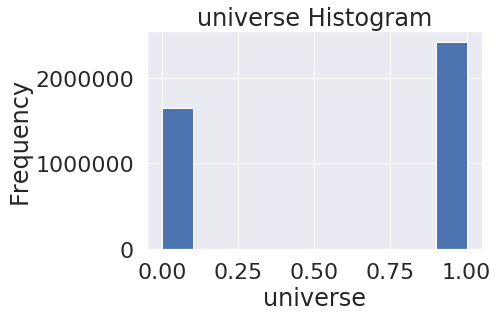

In [40]:
market_train_df['universe'].plot.hist(title = 'universe Histogram');
plt.xlabel('universe');

## 3.5 Simple NLP

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

news_train_df.head()

time      ...       volumeCounts7D
0 2007-01-01 04:29:32+00:00      ...                    7
1 2007-01-01 07:03:35+00:00      ...                    3
2 2007-01-01 11:29:56+00:00      ...                   17
3 2007-01-01 12:08:37+00:00      ...                   15
4 2007-01-01 12:08:37+00:00      ...                    0

[5 rows x 35 columns]

### CountVectorizer

In [42]:
list(news_train_df['headline'])[0:5]

["China's Daqing pumps 43.41 mln tonnes of oil in 06",
 'FEATURE-In kidnapping, finesse works best',
 'PRESS DIGEST - Wall Street Journal - Jan 1',
 'PRESS DIGEST - New York Times - Jan 1',
 'PRESS DIGEST - New York Times - Jan 1']

In [43]:
vect = CountVectorizer()
vect.fit(list(news_train_df['headline']))
vect.vocabulary_

{'china': 64050,
 'daqing': 77366,
 'pumps': 197555,
 '43': 12794,
 '41': 12524,
 'mln': 163366,
 'tonnes': 244147,
 'of': 177429,
 'oil': 178051,
 'in': 128041,
 '06': 942,
 'feature': 100315,
 'kidnapping': 140304,
 'finesse': 102079,
 'works': 264017,
 'best': 47677,
 'press': 194164,
 'digest': 82291,
 'wall': 259245,
 'street': 232340,
 'journal': 136800,
 'jan': 134986,
 'new': 171966,
 'york': 267647,
 'times': 242814,
 'tenet': 240147,
 'completes': 69517,
 'sale': 213562,
 'alvarado': 33406,
 'hospital': 123084,
 'medical': 158419,
 'center': 61707,
 'thc': 241145,
 'rpt': 211433,
 'st': 229851,
 'week': 260690,
 'ahead': 30649,
 'mild': 161748,
 'jobs': 136461,
 'may': 156708,
 'lift': 148158,
 'stocks': 231656,
 'as': 39094,
 '07': 1065,
 'starts': 230486,
 'rite': 209014,
 'aid': 30806,
 'can': 57967,
 'help': 119847,
 'you': 267706,
 'realize': 202489,
 'your': 267759,
 'year': 267112,
 'weight': 260805,
 'loss': 150753,
 'resolution': 206632,
 'rad': 200441,
 'commtouch':

### n-gram

In [44]:
vect = CountVectorizer(ngram_range=(2, 2)).fit(list(news_train_df['headline']))
vect.vocabulary_

{'china daqing': 1433155,
 'daqing pumps': 1821257,
 'pumps 43': 4768150,
 '43 41': 233067,
 '41 mln': 230054,
 'mln tonnes': 3876956,
 'tonnes of': 6014760,
 'of oil': 4190218,
 'oil in': 4241530,
 'in 06': 3057292,
 'feature in': 2409753,
 'in kidnapping': 3071757,
 'kidnapping finesse': 3409601,
 'finesse works': 2460471,
 'works best': 6499993,
 'press digest': 4649465,
 'digest wall': 1955371,
 'wall street': 6353039,
 'street journal': 5662189,
 'journal jan': 3366536,
 'digest new': 1955320,
 'new york': 4053857,
 'york times': 6551567,
 'times jan': 5957193,
 'tenet completes': 5850141,
 'completes sale': 1597916,
 'sale of': 5189593,
 'of alvarado': 4163067,
 'alvarado hospital': 575622,
 'hospital medical': 2963772,
 'medical center': 3769966,
 'center thc': 1360573,
 'rpt wall': 5153264,
 'wall st': 6353034,
 'st week': 5582191,
 'week ahead': 6391315,
 'ahead mild': 509745,
 'mild jobs': 3835356,
 'jobs may': 3350015,
 'may lift': 3743300,
 'lift stocks': 3541409,
 'stocks 

- NLP is the first time I'll study a little more and upload the kernel.

# 4. Time-Series Analysis some Stock

**train_df :** 2007-02-01 ~ 2016-12-30

**test_df:** 2017-01-03

In [45]:
market_train_df.time.head()

0   2007-02-01 22:00:00+00:00
1   2007-02-01 22:00:00+00:00
2   2007-02-01 22:00:00+00:00
3   2007-02-01 22:00:00+00:00
4   2007-02-01 22:00:00+00:00
Name: time, dtype: datetime64[ns, UTC]

In [46]:
market_train_df.time.tail()

4072951   2016-12-30 22:00:00+00:00
4072952   2016-12-30 22:00:00+00:00
4072953   2016-12-30 22:00:00+00:00
4072954   2016-12-30 22:00:00+00:00
4072955   2016-12-30 22:00:00+00:00
Name: time, dtype: datetime64[ns, UTC]

In [47]:
market_obs_df.time.head()

0   2017-01-03 22:00:00+00:00
1   2017-01-03 22:00:00+00:00
2   2017-01-03 22:00:00+00:00
3   2017-01-03 22:00:00+00:00
4   2017-01-03 22:00:00+00:00
Name: time, dtype: datetime64[ns, UTC]

In [48]:
market_obs_df.time.tail()

1818   2017-01-03 22:00:00+00:00
1819   2017-01-03 22:00:00+00:00
1820   2017-01-03 22:00:00+00:00
1821   2017-01-03 22:00:00+00:00
1822   2017-01-03 22:00:00+00:00
Name: time, dtype: datetime64[ns, UTC]

In [49]:
def change_date_to_datetime(x):
    str_time = str(x)
    date = '{}-{}-{}'.format(str_time[:4], str_time[5:7], str_time[8:10])
    return date

market_train_df['date'] = market_train_df['time'].apply(change_date_to_datetime)

In [50]:
market_train_df.head()

time assetCode     ...     universe        date
0 2007-02-01 22:00:00+00:00       A.N     ...          1.0  2007-02-01
1 2007-02-01 22:00:00+00:00     AAI.N     ...          0.0  2007-02-01
2 2007-02-01 22:00:00+00:00     AAP.N     ...          1.0  2007-02-01
3 2007-02-01 22:00:00+00:00    AAPL.O     ...          1.0  2007-02-01
4 2007-02-01 22:00:00+00:00     ABB.N     ...          1.0  2007-02-01

[5 rows x 17 columns]

In [51]:
def add_time_feature(data):
    data['date'] = pd.to_datetime(data['date'])
    data['Year'] = data.date.dt.year
    data['Month'] = data.date.dt.month
    data['Day'] = data.date.dt.day
    data['WeekOfYear'] = data.date.dt.weekofyear
    return data

market_train_df = add_time_feature(market_train_df)

In [52]:
market_train_df.head()

time assetCode     ...     Day  WeekOfYear
0 2007-02-01 22:00:00+00:00       A.N     ...       1           5
1 2007-02-01 22:00:00+00:00     AAI.N     ...       1           5
2 2007-02-01 22:00:00+00:00     AAP.N     ...       1           5
3 2007-02-01 22:00:00+00:00    AAPL.O     ...       1           5
4 2007-02-01 22:00:00+00:00     ABB.N     ...       1           5

[5 rows x 21 columns]

### ECDF: empirical cumulative distribution function

To get the first impression about continious variables in the data we can plot ECDF.

In [53]:
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet

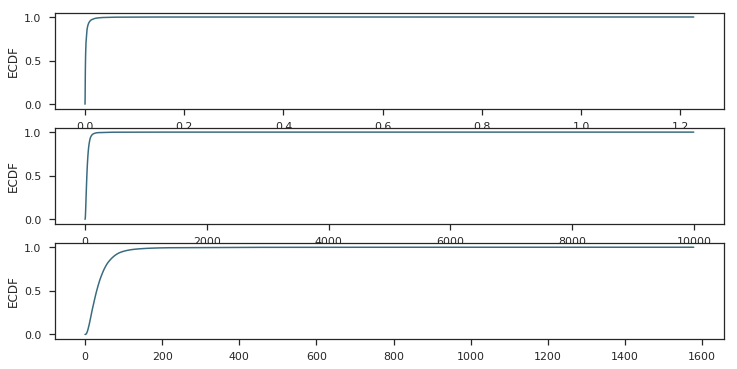

In [54]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(market_train_df['volume'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel(''); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(market_train_df['open'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('');plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(market_train_df['close'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('');plt.ylabel('ECDF');

In [55]:
market_train_df[(market_train_df.assetCode=='A.N')].head()

time assetCode     ...     Day  WeekOfYear
0    2007-02-01 22:00:00+00:00       A.N     ...       1           5
1418 2007-02-02 22:00:00+00:00       A.N     ...       2           5
2841 2007-02-05 22:00:00+00:00       A.N     ...       5           6
4269 2007-02-06 22:00:00+00:00       A.N     ...       6           6
5699 2007-02-07 22:00:00+00:00       A.N     ...       7           6

[5 rows x 21 columns]

### Seasonality

In [56]:
voluem_an = np.transpose(pd.DataFrame([(market_train_df[(market_train_df.assetCode=='A.N')]).set_index('date')['volume']]))

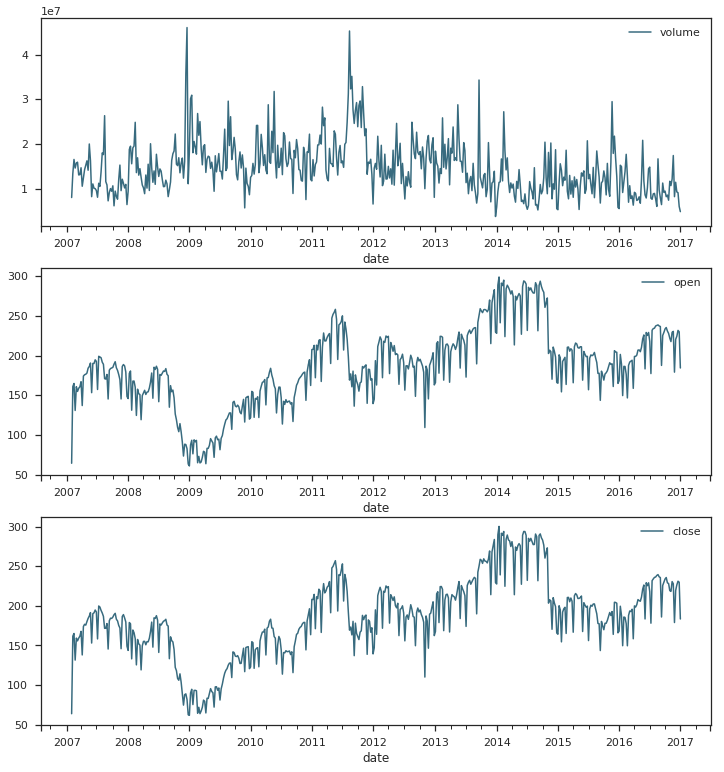

In [57]:
voluem_an = np.transpose(pd.DataFrame([(market_train_df[(market_train_df.assetCode=='A.N')]).set_index('date')['volume']]))
open_an = np.transpose(pd.DataFrame([(market_train_df[(market_train_df.assetCode=='A.N')]).set_index('date')['open']]))
close_an = np.transpose(pd.DataFrame([(market_train_df[(market_train_df.assetCode=='A.N')]).set_index('date')['close']]))

f, (ax1, ax2, ax3) = plt.subplots(3, figsize = (12, 13))

# store types
voluem_an.resample('W').sum().plot(color = c, ax = ax1)
open_an.resample('W').sum().plot(color = c, ax = ax2)
close_an.resample('W').sum().plot(color = c, ax = ax3)

### Yearly

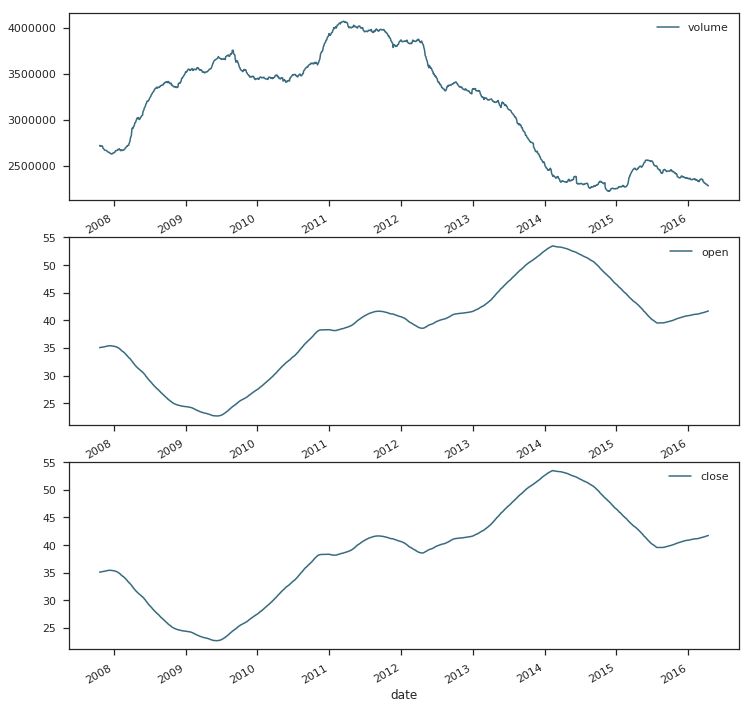

In [58]:
f, (ax1, ax2, ax3) = plt.subplots(3, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(voluem_an, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = seasonal_decompose(open_an, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = seasonal_decompose(close_an, model = 'additive', freq = 365)
decomposition_c.trend.plot(color = c, ax = ax3)

### Autocorrelaion

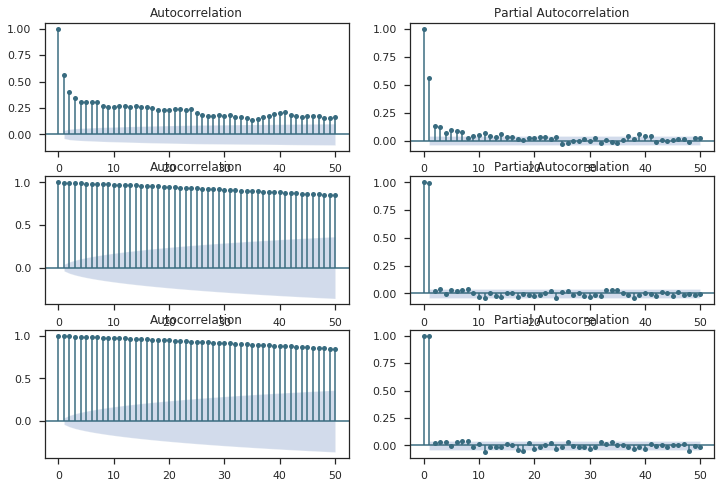

In [59]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for volume
plt.subplot(321); plot_acf(voluem_an, lags = 50, ax = plt.gca(), color = c)
plt.subplot(322); plot_pacf(voluem_an, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for open
plt.subplot(323); plot_acf(open_an, lags = 50, ax = plt.gca(), color = c)
plt.subplot(324); plot_pacf(open_an, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for close
plt.subplot(325); plot_acf(close_an, lags = 50, ax = plt.gca(), color = c)
plt.subplot(326); plot_pacf(close_an, lags = 50, ax = plt.gca(), color = c)

plt.show()

### Time Series Analysis and Forecasting with Prophet

The Core Data Science team at Facebook recently published a new procedure for forecasting time series data called Prophet. It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It enables performing automated forecasting which are already implemented in R at scale in Python 3.

In [60]:
df = market_train_df[(market_train_df["assetCode"] == 'A.N')]

volume = df.loc[:, ['date', 'volume']]

# reverse to the order: from 2013 to 2015
volume = volume.sort_index(ascending = True)

# to datetime64
volume['date'] = pd.DatetimeIndex(volume['date'])
volume.dtypes

# from the prophet documentation every variables should have specific names
volume = volume.rename(columns = {'date': 'ds',
                                'volume': 'y'})
volume.head()

ds          y
0    2007-02-01  2606900.0
1418 2007-02-02  5377400.0
2841 2007-02-05  2512100.0
4269 2007-02-06  2515100.0
5699 2007-02-07  3420200.0

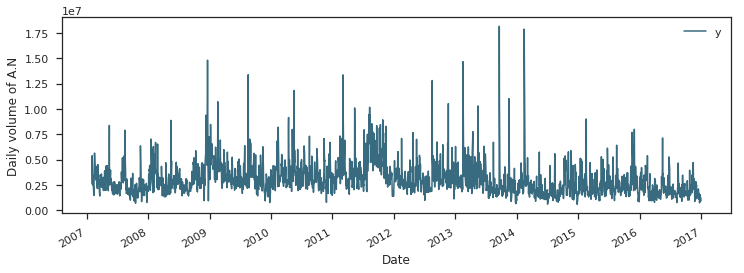

In [61]:
# plot daily sales
ax = volume.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily volume of A.N')
ax.set_xlabel('Date')
plt.show()

In [62]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95)
my_model.fit(volume)

# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 1)

print("First day to forecast.")
future_dates

# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


First day to forecast.


ds          yhat    yhat_lower    yhat_upper
0    2007-02-01  2.988119e+06  3.675593e+05  5.908060e+06
1    2007-02-02  3.004563e+06  1.349709e+05  5.705588e+06
2    2007-02-05  2.731918e+06 -6.910007e+04  5.788947e+06
3    2007-02-06  3.063683e+06  1.941069e+05  5.867543e+06
4    2007-02-07  2.975585e+06  3.144448e+05  5.761008e+06
5    2007-02-08  3.127027e+06  2.038173e+05  5.855052e+06
6    2007-02-09  3.157217e+06  3.650362e+05  6.143890e+06
7    2007-02-12  2.918520e+06  4.957875e+04  5.483000e+06
8    2007-02-13  3.257235e+06  3.643337e+05  5.854027e+06
9    2007-02-14  3.173016e+06  5.682444e+05  6.013094e+06
10   2007-02-15  3.324815e+06  5.891572e+05  6.307157e+06
11   2007-02-16  3.351465e+06  6.262390e+05  6.080681e+06
12   2007-02-20  3.394064e+06  6.388072e+05  6.122414e+06
13   2007-02-21  3.284527e+06  4.476828e+05  6.032866e+06
14   2007-02-22  3.406954e+06  4.733283e+05  6.240128e+06
15   2007-02-23  3.400538e+06  5.248871e+05  6.330749e+06
16   2007-02-26  3.009176e+06  1.458022e+05  5.927110e+06
17   2007-02-27  3.284565e+06  4.519977e+05  6.177516e+06
18   2007-02-28  3.132165e+06  3.055317e+05  6.170423e+06
19   2007-03-01  3.211983e+06  4.345092e+05  6.236249e+06
20   2007-03-02  3.164033e+06  4.596594e+05  6.064131e+06
21   2007-03-05  2.662592e+06 -2.224245e+05  5.560172e+06
22   2007-03-06  2.908641e+06 -7.178669e+04  5.727278e+06
23   2007-03-07  2.731677e+06 -7.119359e+04  5.463429e+06
24   2007-03-08  2.792237e+06 -1.194786e+05  5.529654e+06
25   2007-03-09  2.730762e+06 -4.570852e+04  5.478720e+06
26   2007-03-12  2.225578e+06 -4.734664e+05  5.087652e+06
27   2007-03-13  2.482817e+06 -5.829876e+05  5.387411e+06
28   2007-03-14  2.323012e+06 -6.302124e+05  5.220506e+06
29   2007-03-15  2.406349e+06 -7.223053e+05  5.106473e+06
...         ...           ...           ...           ...
2469 2016-11-18  2.462931e+06 -2.465008e+05  5.394887e+06
2470 2016-11-21  2.115279e+06 -8.743127e+05  4.873248e+06
2471 2016-11-22  2.416020e+06 -4.075840e+05  5.278328e+06
2472 2016-11-23  2.294300e+06 -5.195376e+05  5.109699e+06
2473 2016-11-25  2.402304e+06 -4.527782e+05  5.396700e+06
2474 2016-11-28  2.043754e+06 -8.029594e+05  4.506298e+06
2475 2016-11-29  2.342027e+06 -2.768877e+05  5.274992e+06
2476 2016-11-30  2.218035e+06 -5.906513e+05  5.212512e+06
2477 2016-12-01  2.331300e+06 -3.983682e+05  5.035034e+06
2478 2016-12-02  2.321219e+06 -7.289401e+05  5.059451e+06
2479 2016-12-05  1.952185e+06 -5.923873e+05  4.721040e+06
2480 2016-12-06  2.245667e+06 -6.509852e+05  5.041970e+06
2481 2016-12-07  2.116191e+06 -5.114948e+05  4.985486e+06
2482 2016-12-08  2.223321e+06 -8.184441e+05  5.044316e+06
2483 2016-12-09  2.206551e+06 -7.176188e+05  5.133790e+06
2484 2016-12-12  1.815735e+06 -1.119759e+06  4.411388e+06
2485 2016-12-13  2.102120e+06 -6.979580e+05  4.843508e+06
2486 2016-12-14  1.966067e+06 -8.716653e+05  4.803702e+06
2487 2016-12-15  2.067433e+06 -6.007241e+05  4.938215e+06
2488 2016-12-16  2.046006e+06 -8.681782e+05  4.795780e+06
2489 2016-12-19  1.650686e+06 -1.086743e+06  4.680402e+06
2490 2016-12-20  1.939549e+06 -8.406943e+05  4.805665e+06
2491 2016-12-21  1.808290e+06 -9.216492e+05  4.706735e+06
2492 2016-12-22  1.916886e+06 -1.095595e+06  4.748576e+06
2493 2016-12-23  1.905195e+06 -8.265924e+05  4.641442e+06
2494 2016-12-27  1.861922e+06 -7.716429e+05  4.583519e+06
2495 2016-12-28  1.751762e+06 -1.289889e+06  4.448264e+06
2496 2016-12-29  1.883063e+06 -8.680340e+05  4.773052e+06
2497 2016-12-30  1.895333e+06 -1.278330e+06  4.759562e+06
2498 2016-12-31  1.845692e+06 -8.590324e+05  4.605943e+06

[2499 rows x 4 columns]

In [63]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

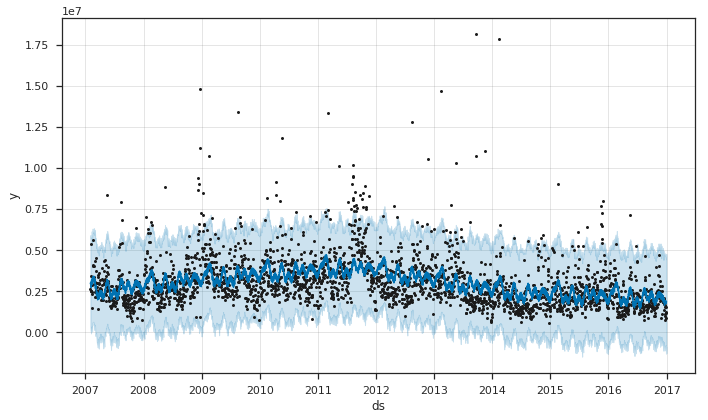

In [64]:
my_model.plot(forecast);

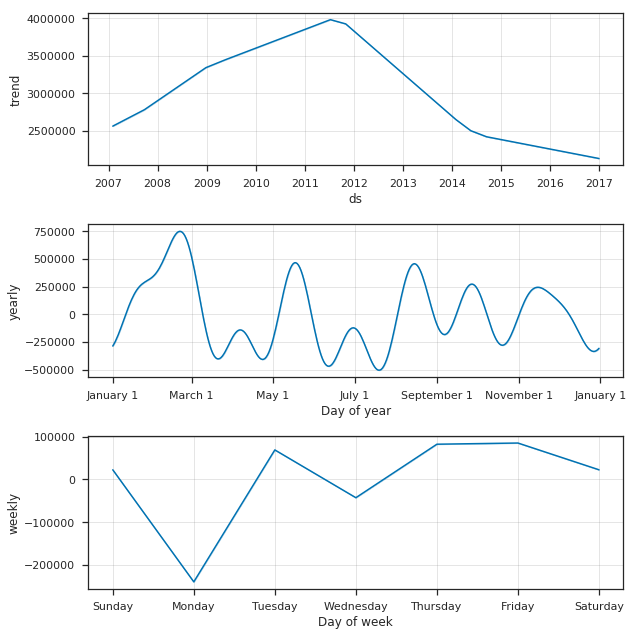

In [66]:
my_model.plot_components(forecast);